# **1. Business Understanding**

In [1]:
# Phase 1 — setup
import os, json, random, numpy as np
from pathlib import Path

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE); random.seed(RANDOM_STATE)

BASE_DIR = Path("/content")          # Colab default working dir
ARTIFACT_DIR = BASE_DIR / "artifacts"
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Artifacts dir: {ARTIFACT_DIR}")
print(f"Random seed: {RANDOM_STATE}")


Artifacts dir: /content/artifacts
Random seed: 42


In [2]:
# Phase 1 — business configuration
config = {
  "project": "Adult Income — CRISP-DM Demo",
  "random_state": 42,

  # Target definition
  "target": "income",
  "positive_label": ">50K",

  # Metrics & policy
  "primary_metric": "average_precision",     # PR-AUC
  "secondary_metrics": ["roc_auc", "f1", "precision", "recall"],
  "threshold_policy": "minimize_cost",
  "cost_matrix": {"FP": 1.0, "FN": 5.0},

  # Fairness audit slices (auditing only)
  "fairness_slices": ["sex", "race"],

  # Data location strategy (Phase 2 will honor this)
  "data": {
    "local_drive_path": "/content/drive/MyDrive/adult.csv",
    "fallback": {
      "train_url": "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
      "test_url":  "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
      "names_url": "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names"
    }
  },

  # Artifacts
  "artifacts": {
    "model_path": str(ARTIFACT_DIR / "model.pkl"),
    "metrics_path": str(ARTIFACT_DIR / "metrics.json"),
    "prep_path": str(ARTIFACT_DIR / "prep.pkl"),
    "config_path": str(ARTIFACT_DIR / "config.json")
  }
}

with open(ARTIFACT_DIR / "config.json", "w") as f:
    json.dump(config, f, indent=2)

print("Saved:", ARTIFACT_DIR / "config.json")


Saved: /content/artifacts/config.json


In [3]:
# Phase 1 — summary
import json, pprint, pathlib
cfg = json.loads(pathlib.Path(ARTIFACT_DIR / "config.json").read_text())
pp = pprint.PrettyPrinter(indent=2, width=100)
pp.pprint({
    "project": cfg["project"],
    "target": (cfg["target"], cfg["positive_label"]),
    "primary_metric": cfg["primary_metric"],
    "cost_matrix": cfg["cost_matrix"],
    "threshold_policy": cfg["threshold_policy"],
    "fairness_slices": cfg["fairness_slices"],
    "artifacts": cfg["artifacts"]
})


{ 'artifacts': { 'config_path': '/content/artifacts/config.json',
                 'metrics_path': '/content/artifacts/metrics.json',
                 'model_path': '/content/artifacts/model.pkl',
                 'prep_path': '/content/artifacts/prep.pkl'},
  'cost_matrix': {'FN': 5.0, 'FP': 1.0},
  'fairness_slices': ['sex', 'race'],
  'primary_metric': 'average_precision',
  'project': 'Adult Income — CRISP-DM Demo',
  'target': ('income', '>50K'),
  'threshold_policy': 'minimize_cost'}


# **2. Data Understanding**

In [4]:
# Phase 2 — cell 1: Load data with Drive-first, UCI fallback
import pandas as pd, numpy as np, json, os
from pathlib import Path

# Read Phase-1 config if present, else use sane defaults
ARTIFACT_DIR = Path("/content/artifacts")
cfg_path = ARTIFACT_DIR / "config.json"
if cfg_path.exists():
    config = json.loads(cfg_path.read_text())
else:
    config = {
        "target": "income",
        "positive_label": ">50K",
        "data": {
            "local_drive_path": "/content/drive/MyDrive/adult.csv",
            "fallback": {
                "train_url": "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                "test_url":  "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
            }
        }
    }

TARGET = config.get("target", "income")
POS_LABEL = config.get("positive_label", ">50K")

# Try to mount Google Drive (Colab)
try:
    from google.colab import drive  # will succeed in Colab
    drive.mount('/content/drive', force_remount=False)
except Exception as e:
    print("Note: Colab Drive not available in this environment. Proceeding without explicit mount.")

# Expected Adult schema (order matters)
EXPECTED_COLS = [
    "age","workclass","fnlwgt","education","education-num","marital-status",
    "occupation","relationship","race","sex","capital-gain","capital-loss",
    "hours-per-week","native-country","income"
]

local_path = Path(config["data"]["local_drive_path"])
provenance = None

def clean_income_series(s):
    s = s.astype(str).str.strip().str.replace(".", "", regex=False)
    return s

if local_path.exists():
    df = pd.read_csv(local_path)
    provenance = f"drive_csv:{local_path}"
else:
    # UCI fallback: load TRAIN for EDA, keep TEST rows count noted (held-out usage later)
    cols = EXPECTED_COLS
    tr_url = config["data"]["fallback"]["train_url"]
    te_url = config["data"]["fallback"]["test_url"]

    df_train = pd.read_csv(tr_url, header=None, names=cols,
                           na_values=["?"], skipinitialspace=True)
    df_test  = pd.read_csv(te_url, header=None, names=cols,
                           na_values=["?"], skipinitialspace=True, skiprows=1)
    # Normalize trailing periods and stray spaces in target for test; we EDA on train only
    df_train[TARGET] = clean_income_series(df_train[TARGET])
    df_test[TARGET]  = clean_income_series(df_test[TARGET])

    df = df_train.copy()
    provenance = "uci_fallback:train_only"

# Normalize Drive CSV to expected schema/labels
# 1) Trim object columns and convert "?" -> NA (if present)
for c in df.columns:
    if df[c].dtype == object:
        df[c] = df[c].astype(str).str.strip().replace({"?": np.nan})

# 2) Ensure expected columns and order if possible
if set(EXPECTED_COLS).issubset(set(df.columns)):
    df = df[EXPECTED_COLS]
else:
    print("Warning: Columns differ from expected; proceeding with current columns.")

# 3) Normalize target to {<=50K, >50K}
if TARGET in df.columns:
    df[TARGET] = clean_income_series(df[TARGET])

# Restrict to the two canonical labels, drop weird rows if any
valid_labels = {"<=50K", ">50K"}
if TARGET in df.columns:
    before = len(df)
    df = df[df[TARGET].isin(valid_labels)].copy()
    dropped = before - len(df)
    if dropped > 0:
        print(f"Dropped {dropped} rows with non-standard target labels.")

print(f"Loaded from: {provenance}; shape={df.shape}")
df.head(3)


Mounted at /content/drive
Loaded from: drive_csv:/content/drive/MyDrive/adult.csv; shape=(32561, 15)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K


In [5]:
# Phase 2 — cell 2: Quick audit of structure & health
import numpy as np

print("Shape:", df.shape)
print("\nDtypes:")
print(df.dtypes)

# Missingness summary (top 10 by missing rate)
na_rate = df.isna().mean().sort_values(ascending=False)
print("\nMissingness (top 10):")
print((na_rate.head(10) * 100).round(2).astype(str) + "%")

# Target prevalence (class imbalance)
if TARGET in df.columns:
    pos_rate = (df[TARGET] == POS_LABEL).mean()
    print(f"\nTarget prevalence ({POS_LABEL}): {pos_rate:.3f}")

# Duplicate rows
dup_count = df.duplicated().sum()
dup_pct = dup_count / len(df) if len(df) else 0.0
print(f"\nDuplicate rows: {dup_count} ({dup_pct:.2%})")

# Basic numeric summary (compact)
num_cols = [c for c in df.columns if df[c].dtype != 'O' and c != TARGET]
print("\nNumeric columns:", num_cols)
display(df[num_cols].describe().T.iloc[:, :6])  # count, mean, std, min, 25%, 50%


Shape: (32561, 15)

Dtypes:
age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

Missingness (top 10):
occupation        5.66%
workclass         5.64%
native.country    1.79%
fnlwgt             0.0%
education          0.0%
education.num      0.0%
age                0.0%
marital.status     0.0%
relationship       0.0%
sex                0.0%
dtype: object

Target prevalence (>50K): 0.241

Duplicate rows: 24 (0.07%)

Numeric columns: ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']


,count,mean,std,min,25%,50%
age,32561.0,38.581647,13.640433,17.0,28.0,37.0
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0
education.num,32561.0,10.080679,2.572720,1.0,9.0,10.0
capital.gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0
capital.loss,32561.0,87.303830,402.960219,0.0,0.0,0.0
hours.per.week,32561.0,40.437456,12.347429,1.0,40.0,40.0


Categorical cardinality (top 10):
native.country    41
education         16
occupation        14
workclass          8
marital.status     7
relationship       6
race               5
sex                2
dtype: int64

Positive rate by sex:
sex
Male      0.306
Female    0.109
Name: income, dtype: float64

Positive rate by race:
race
Asian-Pac-Islander    0.266
White                 0.256
Black                 0.124
Amer-Indian-Eskimo    0.116
Other                 0.092
Name: income, dtype: float64


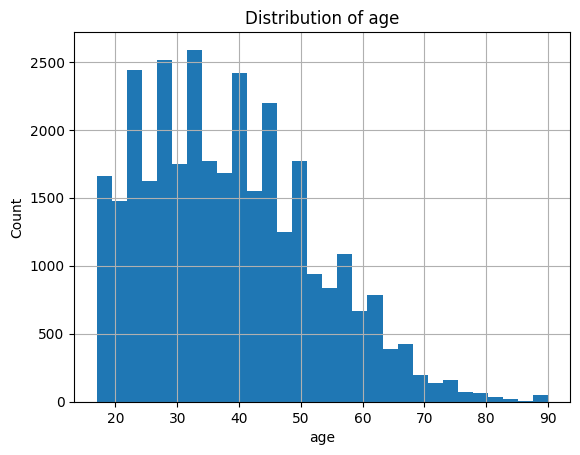

In [6]:
# Phase 2 — cell 3: Cardinality + fairness + quick dists
import matplotlib.pyplot as plt

# Identify categorical columns (exclude target)
cat_cols = [c for c in df.columns if df[c].dtype == 'O' and c != TARGET]

# Cardinality overview (top 10)
card = df[cat_cols].nunique().sort_values(ascending=False)
print("Categorical cardinality (top 10):")
print(card.head(10))

# Peek at most diverse field (often native-country)
if "native-country" in df.columns:
    print("\nTop 10 'native-country' values:")
    print(df["native-country"].value_counts(dropna=False).head(10))

# Fairness slices — positive rate by sex and race
if TARGET in df.columns:
    y = (df[TARGET] == POS_LABEL).astype(int)
    if "sex" in df.columns:
        print("\nPositive rate by sex:")
        print(y.groupby(df["sex"]).mean().sort_values(ascending=False).round(3))
    if "race" in df.columns:
        print("\nPositive rate by race:")
        print(y.groupby(df["race"]).mean().sort_values(ascending=False).round(3))

# Quick histograms for two key numeric features
for col in ["age", "hours-per-week"]:
    if col in df.columns and np.issubdtype(df[col].dtype, np.number):
        plt.figure()
        df[col].hist(bins=30)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col); plt.ylabel("Count")
        plt.show()


# **3. Data Preparation**

In [7]:
# Phase 3 — cell 1: feature lists, dedup, and splits
import json, numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

assert 'df' in globals(), "DataFrame `df` not found. Please run Phase 2 cells first."

ARTIFACT_DIR = Path("/content/artifacts")
cfg_path = ARTIFACT_DIR / "config.json"
config = json.loads(cfg_path.read_text()) if cfg_path.exists() else {}
TARGET = config.get("target", "income")
POS_LABEL = config.get("positive_label", ">50K")

# Expected columns
NUM_COLS = ["age","fnlwgt","education-num","capital-gain","capital-loss","hours-per-week"]
CAT_COLS = ["workclass","education","marital-status","occupation","relationship","native-country"]  # exclude sex, race
AUDIT_COLS = ["sex","race"]

# Keep only columns we actually have
NUM = [c for c in NUM_COLS if c in df.columns]
CAT = [c for c in CAT_COLS if c in df.columns]
AUDIT = [c for c in AUDIT_COLS if c in df.columns]
cols_needed = NUM + CAT + AUDIT + ([TARGET] if TARGET in df.columns else [])
df = df[cols_needed].copy()

# Drop exact duplicates before splitting
before = len(df)
df = df.drop_duplicates()
print(f"Dropped {before - len(df)} exact duplicates.")

# Determine split strategy
provenance_str = globals().get('provenance', 'drive_csv:unknown')
print("Provenance:", provenance_str)

def clean_income_series(s):
    return s.astype(str).str.strip().str.replace(".", "", regex=False)

# UCI fallback path: use held-out test from UCI, and split df(train) -> train/valid
if "uci_fallback" in provenance_str:
    fb = config.get("data", {}).get("fallback", {})
    test_url = fb.get("test_url", "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test")
    # reload a clean test set with matching columns (for later phases)
    EXPECTED_COLS = NUM_COLS + ["workclass","education","marital-status","occupation","relationship","race","sex","native-country","income"]
    df_test = pd.read_csv(test_url, header=None, names=EXPECTED_COLS, na_values=["?"], skipinitialspace=True, skiprows=1)
    df_test[TARGET] = clean_income_series(df_test[TARGET])
    # Align to our working set of columns
    df_test = df_test[[c for c in cols_needed if c in df_test.columns]].copy()
    # Train/valid split from df (train)
    y_all = (df[TARGET] == POS_LABEL).astype(int)
    X_all = df.drop(columns=[TARGET])
    X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(
        X_all, y_all, test_size=0.20, stratify=y_all, random_state=42
    )
    # Test (held-out)
    y_test = (df_test[TARGET] == POS_LABEL).astype(int) if TARGET in df_test else None
    X_test_raw = df_test.drop(columns=[TARGET]) if TARGET in df_test else df_test.copy()
else:
    # Single CSV (Drive): do 70/15/15 stratified split
    y_all = (df[TARGET] == POS_LABEL).astype(int)
    X_all = df.drop(columns=[TARGET])
    X_train_raw, X_tmp, y_train, y_tmp = train_test_split(
        X_all, y_all, test_size=0.30, stratify=y_all, random_state=42
    )
    X_valid_raw, X_test_raw, y_valid, y_test = train_test_split(
        X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=42
    )

# Keep audit columns (sex, race) separately for Evaluation slices later
audit_valid = X_valid_raw[AUDIT].copy() if len(AUDIT) else pd.DataFrame(index=X_valid_raw.index)
audit_test  = X_test_raw[AUDIT].copy()  if len(AUDIT) else pd.DataFrame(index=X_test_raw.index)

# Remove audit columns from model features
X_train_raw = X_train_raw.drop(columns=[c for c in AUDIT if c in X_train_raw.columns], errors="ignore")
X_valid_raw = X_valid_raw.drop(columns=[c for c in AUDIT if c in X_valid_raw.columns], errors="ignore")
X_test_raw  = X_test_raw.drop(columns=[c for c in AUDIT if c in X_test_raw.columns], errors="ignore")

print("Shapes (raw):")
print("  Train:", X_train_raw.shape, "Valid:", X_valid_raw.shape, "Test:", X_test_raw.shape)
print("  Features used:", list(X_train_raw.columns))


Dropped 78 exact duplicates.
Provenance: drive_csv:/content/drive/MyDrive/adult.csv
Shapes (raw):
  Train: (22738, 6) Valid: (4872, 6) Test: (4873, 6)
  Features used: ['age', 'fnlwgt', 'workclass', 'education', 'occupation', 'relationship']


In [9]:
# Phase 3 — cell 2: define the preprocessing pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np

class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    """Map infrequent categories (< min_freq of rows) to 'Other', per column."""
    def __init__(self, min_freq=0.005, other_label="Other"):
        self.min_freq = min_freq
        self.other_label = other_label
        self.keepers_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        self.columns_ = list(X.columns)
        n = len(X)
        for c in self.columns_:
            vc = X[c].value_counts(dropna=False)
            keep = set(vc[vc >= max(1, int(self.min_freq * n))].index.tolist())
            self.keepers_[c] = keep
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for c in self.columns_:
            keep = self.keepers_[c]
            X[c] = X[c].where(X[c].isin(keep), other=self.other_label)
        return X

# Columns present in the raw features (audit already removed)
present_num = [c for c in NUM_COLS if c in X_train_raw.columns]
present_cat = [c for c in CAT_COLS if c in X_train_raw.columns]

# Split numeric into (gain/loss) vs other numerics for log1p
gainloss = [c for c in ["capital-gain","capital-loss"] if c in present_num]
num_other = [c for c in present_num if c not in gainloss]

num_other_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

num_gainloss_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("log1p", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
    ("scale", StandardScaler())
])

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("rare", RareCategoryGrouper(min_freq=0.005, other_label="Other")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

prep = ColumnTransformer(
    transformers=[
        ("num_other", num_other_pipe, num_other),
        ("num_gainloss", num_gainloss_pipe, gainloss),
        ("cat", cat_pipe, present_cat),
    ],
    remainder="drop"
)

prep_pipeline = Pipeline([("prep", prep)])  # single named step for clarity
print("Preprocessing pipeline defined.")

Preprocessing pipeline defined.


In [10]:
# Phase 3 — cell 3: fit/transform and save artifact
from joblib import dump

# Fit on TRAIN ONLY
prep_pipeline.fit(X_train_raw, y_train)

# Transform splits
X_train = prep_pipeline.transform(X_train_raw)
X_valid = prep_pipeline.transform(X_valid_raw)
X_test  = prep_pipeline.transform(X_test_raw)

# Persist preprocessing artifact
prep_path = ARTIFACT_DIR / "prep.pkl"
dump(prep_pipeline, prep_path)
print(f"Saved preprocessing pipeline to: {prep_path}")

# Quick shape sanity + feature count
feat_count = X_train.shape[1]
print("Prepared shapes:")
print("  X_train:", X_train.shape, " X_valid:", X_valid.shape, " X_test:", X_test.shape)
print("  #Features after prep:", feat_count)

# Keep these in memory for next phases
_prepared_cache = {
    "X_train": X_train, "y_train": y_train.values,
    "X_valid": X_valid, "y_valid": y_valid.values,
    "X_test":  X_test,  "y_test":  None if y_test is None else y_test.values,
    "audit_valid": audit_valid, "audit_test": audit_test,
    "feature_count": feat_count
}
print("Cached prepared arrays for Modeling/Evaluation.")


Saved preprocessing pipeline to: /content/artifacts/prep.pkl
Prepared shapes:
  X_train: (22738, 44)  X_valid: (4872, 44)  X_test: (4873, 44)
  #Features after prep: 44
Cached prepared arrays for Modeling/Evaluation.


# **4. Modeling**

In [11]:
# Phase 4 — cell 1: load prepared matrices from cache
import numpy as np, json
from pathlib import Path

ARTIFACT_DIR = Path("/content/artifacts")
assert '_prepared_cache' in globals(), "Prepared arrays not found. Please run Phase 3 cells first."

X_train = _prepared_cache["X_train"]; y_train = _prepared_cache["y_train"]
X_valid = _prepared_cache["X_valid"]; y_valid = _prepared_cache["y_valid"]
X_test  = _prepared_cache["X_test"];  y_test  = _prepared_cache["y_test"]  # kept unused here

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)
print("Pos rate (train/valid):",
      f"{y_train.mean():.3f}/{y_valid.mean():.3f}")


Train: (22738, 44) Valid: (4872, 44) Test: (4873, 44)
Pos rate (train/valid): 0.241/0.241


In [12]:
# Phase 4 — cell 2: fit small grids and score by PR-AUC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import average_precision_score
import pandas as pd

results = []

def fit_and_score(model, name, params):
    model.set_params(**params)
    model.fit(X_train, y_train)
    # All candidates must output probabilities for PR-AUC
    proba_valid = model.predict_proba(X_valid)[:, 1]
    ap = average_precision_score(y_valid, proba_valid)
    results.append({
        "model": name, **params, "valid_pr_auc": ap, "estimator": model, "proba_valid": proba_valid
    })

# Logistic Regression
for C in [0.1, 1.0, 3.0]:
    fit_and_score(LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
                  "LogisticRegression", {"C": C, "solver": "lbfgs"})

# Random Forest
for n in [200, 400]:
    for depth in [None, 12]:
        for leaf in [1, 5]:
            fit_and_score(RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
                          "RandomForest",
                          {"n_estimators": n, "max_depth": depth, "min_samples_leaf": leaf})

# HistGradientBoosting
for lr in [0.1, 0.05]:
    for depth in [None, 6]:
        fit_and_score(HistGradientBoostingClassifier(random_state=RANDOM_STATE),
                      "HistGradientBoosting",
                      {"learning_rate": lr, "max_depth": depth})

leaderboard = (pd.DataFrame(results)
               .drop(columns=["estimator","proba_valid"])
               .sort_values("valid_pr_auc", ascending=False)
               .reset_index(drop=True))
leaderboard.head(10)


/usr/local/lib/python3.12/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


,model,C,solver,valid_pr_auc,n_estimators,max_depth,min_samples_leaf,learning_rate
0,HistGradientBoosting,NaN,NaN,0.719971,NaN,6.0,NaN,0.10
1,HistGradientBoosting,NaN,NaN,0.718760,NaN,6.0,NaN,0.05
2,HistGradientBoosting,NaN,NaN,0.716819,NaN,NaN,NaN,0.10
3,HistGradientBoosting,NaN,NaN,0.716678,NaN,NaN,NaN,0.05
4,RandomForest,NaN,NaN,0.709153,200.0,12.0,5.0,NaN
5,RandomForest,NaN,NaN,0.708921,400.0,12.0,5.0,NaN
6,RandomForest,NaN,NaN,0.706343,400.0,NaN,5.0,NaN
7,RandomForest,NaN,NaN,0.705888,200.0,NaN,5.0,NaN
8,RandomForest,NaN,NaN,0.705480,400.0,12.0,1.0,NaN
9,RandomForest,NaN,NaN,0.704352,200.0,12.0,1.0,NaN


In [13]:
# Phase 4 — cell 3: persist best model and validation probabilities
from joblib import dump

best = max(results, key=lambda r: r["valid_pr_auc"])
best_model = best["estimator"]
best_name = best["model"]; best_params = {k:v for k,v in best.items() if k not in {"model","valid_pr_auc","estimator","proba_valid"}}
best_ap = best["valid_pr_auc"]
val_proba = best["proba_valid"]

# Save model
model_path = ARTIFACT_DIR / "model.pkl"
dump(best_model, model_path)

# Save validation probabilities & labels for Evaluation phase
np.save(ARTIFACT_DIR / "val_proba.npy", val_proba)
np.save(ARTIFACT_DIR / "val_labels.npy", y_valid)

print("Best model:", best_name, best_params)
print(f"Validation PR-AUC: {best_ap:.4f}")
print(f"Saved model → {model_path}")
print("Saved val_proba.npy and val_labels.npy for cost-based thresholding next.")


Best model: HistGradientBoosting {'learning_rate': 0.1, 'max_depth': 6}
Validation PR-AUC: 0.7200
Saved model → /content/artifacts/model.pkl
Saved val_proba.npy and val_labels.npy for cost-based thresholding next.


# **5. Evaluation**

Validation PR-AUC: 0.7200
Validation ROC-AUC: 0.8919


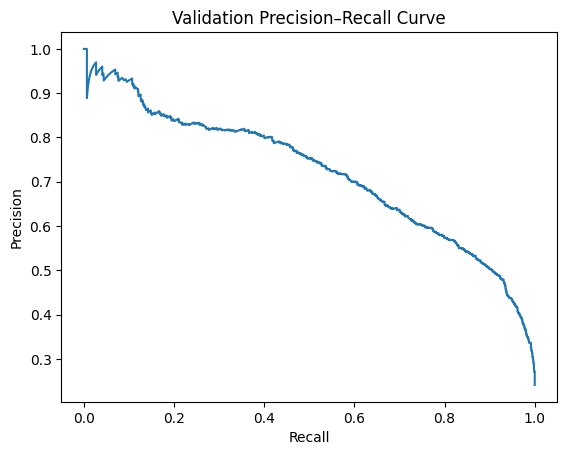

In [14]:
# Phase 5 — cell 1: top-line validation metrics & PR curve
import json, numpy as np, pandas as pd
from pathlib import Path
from joblib import load
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve

ARTIFACT_DIR = Path("/content/artifacts")
assert '_prepared_cache' in globals(), "Prepared arrays cache missing. Please run Phase 3."

# Load prepared data (no leaks)
X_valid = _prepared_cache["X_valid"]; y_valid = _prepared_cache["y_valid"]
X_test  = _prepared_cache["X_test"];  y_test  = _prepared_cache["y_test"]
audit_valid = _prepared_cache["audit_valid"]; audit_test = _prepared_cache["audit_test"]

# Load model and (cached) validation probabilities or recompute if needed
model = load(ARTIFACT_DIR / "model.pkl")
val_proba_path = ARTIFACT_DIR / "val_proba.npy"
val_labels_path = ARTIFACT_DIR / "val_labels.npy"
if val_proba_path.exists() and val_labels_path.exists():
    proba_valid = np.load(val_proba_path)
    yv = np.load(val_labels_path)
    # sanity alignment
    if len(yv) == len(y_valid):
        y_valid = yv
else:
    # Fallback: compute now (should match Phase 4)
    proba_valid = model.predict_proba(X_valid)[:, 1]

# Primary & secondary metrics (validation, threshold-free)
pr_auc_val  = float(average_precision_score(y_valid, proba_valid))
roc_auc_val = float(roc_auc_score(y_valid, proba_valid))

print(f"Validation PR-AUC: {pr_auc_val:.4f}")
print(f"Validation ROC-AUC: {roc_auc_val:.4f}")

# PR curve
prec, rec, thr = precision_recall_curve(y_valid, proba_valid)
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Validation Precision–Recall Curve")
plt.show()


In [15]:
# Phase 5 — cell 2: choose τ* by minimizing expected cost; report validation metrics, calibration, fairness
from sklearn.metrics import brier_score_loss

# Load cost matrix from config (defaults FP=1, FN=5)
config = json.loads((ARTIFACT_DIR / "config.json").read_text()) if (ARTIFACT_DIR / "config.json").exists() else {}
costs = config.get("cost_matrix", {"FP": 1.0, "FN": 5.0})
C_FP = float(costs.get("FP", 1.0))
C_FN = float(costs.get("FN", 5.0))

def metrics_at_threshold(y_true, proba, t):
    y_pred = (proba >= t).astype(int)
    TP = int(((y_true==1) & (y_pred==1)).sum())
    FP = int(((y_true==0) & (y_pred==1)).sum())
    TN = int(((y_true==0) & (y_pred==0)).sum())
    FN = int(((y_true==1) & (y_pred==0)).sum())
    precision = TP / (TP+FP) if (TP+FP)>0 else np.nan
    recall    = TP / (TP+FN) if (TP+FN)>0 else np.nan
    f1        = (2*precision*recall)/(precision+recall) if (precision>0 and recall>0) else np.nan
    fpr       = FP / (FP+TN) if (FP+TN)>0 else np.nan
    fnr       = FN / (TP+FN) if (TP+FN)>0 else np.nan
    pos_rate  = y_pred.mean()
    exp_cost  = C_FP*FP + C_FN*FN
    return {"t":t, "TP":TP,"FP":FP,"TN":TN,"FN":FN,
            "precision":precision,"recall":recall,"f1":f1,
            "fpr":fpr,"fnr":fnr,"pos_rate":float(pos_rate),"exp_cost":float(exp_cost)}

# Threshold sweep on a fixed grid for stability
grid = np.linspace(0, 1, 1001)
rows = [metrics_at_threshold(y_valid, proba_valid, t) for t in grid]
thr_df = pd.DataFrame(rows).sort_values("exp_cost", ascending=True)

# Pick τ* = min expected cost; tie-break on highest F1
best_cost = thr_df["exp_cost"].min()
candidates = thr_df[thr_df["exp_cost"] == best_cost]
best_row = candidates.sort_values("f1", ascending=False).iloc[0]
tau = float(best_row["t"])

print("Chosen threshold τ* (validation, min expected cost):", round(tau, 4))
display(thr_df.head(10)[["t","exp_cost","precision","recall","f1","pos_rate"]])

# Validation metrics at τ*
val_metrics = metrics_at_threshold(y_valid, proba_valid, tau)
print("\nValidation @ τ*")
for k in ["precision","recall","f1","fpr","fnr","pos_rate"]:
    print(f"{k}: {val_metrics[k]:.4f}" if pd.notna(val_metrics[k]) else f"{k}: nan")
print(f"Confusion (TP/FP/TN/FN): {val_metrics['TP']}/{val_metrics['FP']}/{val_metrics['TN']}/{val_metrics['FN']}")
print(f"Expected cost (FP={C_FP}, FN={C_FN}): {val_metrics['exp_cost']:.2f}")

# Calibration: Brier + 10-bin reliability table (equal-width bins)
brier_val = float(brier_score_loss(y_valid, proba_valid))
bins = np.linspace(0, 1, 11)
bin_ids = np.digitize(proba_valid, bins) - 1
cal_rows = []
for b in range(10):
    mask = bin_ids == b
    if mask.sum() == 0:
        cal_rows.append({"bin":[bins[b],bins[b+1]], "n":0, "pred_mean":np.nan, "actual_rate":np.nan})
    else:
        cal_rows.append({
            "bin": [float(bins[b]), float(bins[b+1])],
            "n": int(mask.sum()),
            "pred_mean": float(proba_valid[mask].mean()),
            "actual_rate": float(y_valid[mask].mean())
        })
cal_table = pd.DataFrame(cal_rows)
print(f"\nValidation Brier score: {brier_val:.4f}")
display(cal_table)

# Fairness slices (validation) at τ*
from sklearn.metrics import average_precision_score

def slice_report(y_true, proba, y_pred, series):
    out = {}
    for g in series.dropna().unique():
        idx = (series == g).values
        yg, pg, yp = y_true[idx], proba[idx], y_pred[idx]
        if len(yg) == 0:
            continue
        TP = int(((yg==1) & (yp==1)).sum())
        FP = int(((yg==0) & (yp==1)).sum())
        TN = int(((yg==0) & (yp==0)).sum())
        FN = int(((yg==1) & (yp==0)).sum())
        precision = TP / (TP+FP) if (TP+FP)>0 else np.nan
        recall    = TP / (TP+FN) if (TP+FN)>0 else np.nan
        fpr       = FP / (FP+TN) if (FP+TN)>0 else np.nan
        fnr       = FN / (TP+FN) if (TP+FN)>0 else np.nan
        pos_rate  = yp.mean()
        pr_auc = np.nan
        # PR-AUC per slice requires at least one positive
        if yg.sum() > 0:
            try:
                pr_auc = float(average_precision_score(yg, pg))
            except Exception:
                pr_auc = np.nan
        out[str(g)] = {
            "n": int(len(yg)),
            "pos_rate": float(pos_rate),
            "precision": precision, "recall": recall,
            "fpr": fpr, "fnr": fnr,
            "pr_auc": pr_auc
        }
    return out

y_pred_val = (proba_valid >= tau).astype(int)
fair_val = {}
if "sex" in audit_valid.columns:
    fair_val["sex"] = slice_report(y_valid, proba_valid, y_pred_val, audit_valid["sex"])
if "race" in audit_valid.columns:
    fair_val["race"] = slice_report(y_valid, proba_valid, y_pred_val, audit_valid["race"])

print("\nValidation fairness (per-slice):")
for dim, groups in fair_val.items():
    print(f"\nBy {dim}:")
    for g, m in groups.items():
        print(f"  {g:>15} | n={m['n']:>4} | pos_rate={m['pos_rate']:.3f} | prec={m['precision']:.3f} "
              f"| rec={m['recall']:.3f} | FPR={m['fpr']:.3f} | FNR={m['fnr']:.3f} | PR-AUC={m['pr_auc'] if m['pr_auc']==m['pr_auc'] else 'nan'}")  # NaN guard


Chosen threshold τ* (validation, min expected cost): 0.16


,t,exp_cost,precision,recall,f1,pos_rate
160,0.160,1590.0,0.487410,0.923339,0.638022,0.456486
152,0.152,1594.0,0.479789,0.930153,0.633043,0.467159
159,0.159,1595.0,0.486317,0.923339,0.637085,0.457512
151,0.151,1601.0,0.478318,0.930153,0.631762,0.468596
164,0.164,1603.0,0.489777,0.918228,0.638815,0.451765
163,0.163,1605.0,0.488456,0.919080,0.637895,0.453407
161,0.161,1607.0,0.487145,0.919932,0.636980,0.455049
158,0.158,1607.0,0.483713,0.923339,0.634846,0.459975
166,0.166,1608.0,0.491316,0.915673,0.639500,0.449097
150,0.150,1608.0,0.476045,0.931005,0.629971,0.471264



Validation @ τ*
precision: 0.4874
recall: 0.9233
f1: 0.6380
fpr: 0.3083
fnr: 0.0767
pos_rate: 0.4565
Confusion (TP/FP/TN/FN): 1084/1140/2558/90
Expected cost (FP=1.0, FN=5.0): 1590.00

Validation Brier score: 0.1101


,bin,n,pred_mean,actual_rate
0,"[0.0, 0.1]",2228,0.030320,0.023788
1,"[0.1, 0.2]",649,0.145913,0.134052
2,"[0.2, 0.30000000000000004]",391,0.244153,0.263427
3,"[0.30000000000000004, 0.4]",331,0.350214,0.350453
4,"[0.4, 0.5]",305,0.447545,0.419672
5,"[0.5, 0.6000000000000001]",238,0.547276,0.537815
6,"[0.6000000000000001, 0.7000000000000001]",304,0.649631,0.694079
7,"[0.7000000000000001, 0.8]",249,0.746151,0.775100
8,"[0.8, 0.9]",123,0.842235,0.845528
9,"[0.9, 1.0]",54,0.925678,0.944444



Validation fairness (per-slice):

By sex:
             Male | n=3241 | pos_rate=0.570 | prec=0.505 | rec=0.941 | FPR=0.406 | FNR=0.059 | PR-AUC=0.7333890862756867
           Female | n=1631 | pos_rate=0.231 | prec=0.403 | rec=0.826 | FPR=0.155 | FNR=0.174 | PR-AUC=0.6492438506287489

By race:
            White | n=4135 | pos_rate=0.480 | prec=0.494 | rec=0.928 | FPR=0.326 | FNR=0.072 | PR-AUC=0.7244648082905635
  Asian-Pac-Islander | n= 154 | pos_rate=0.474 | prec=0.562 | rec=0.804 | FPR=0.311 | FNR=0.196 | PR-AUC=0.787459718571912
            Black | n= 497 | pos_rate=0.274 | prec=0.397 | rec=0.947 | FPR=0.186 | FNR=0.053 | PR-AUC=0.6360987810281135
  Amer-Indian-Eskimo | n=  40 | pos_rate=0.275 | prec=0.364 | rec=1.000 | FPR=0.194 | FNR=0.000 | PR-AUC=0.7321428571428572
            Other | n=  46 | pos_rate=0.391 | prec=0.167 | rec=0.750 | FPR=0.357 | FNR=0.250 | PR-AUC=0.3125


In [16]:
# Phase 5 — cell 3: test evaluation with fixed τ*, persist artifacts
from sklearn.metrics import average_precision_score, roc_auc_score

# Compute test probabilities once (no re-tuning)
proba_test = model.predict_proba(X_test)[:, 1]

# Threshold-free
pr_auc_test  = float(average_precision_score(y_test, proba_test)) if y_test is not None else None
roc_auc_test = float(roc_auc_score(y_test, proba_test)) if y_test is not None else None

# Thresholded (if labels exist)
test_metrics = None
fair_test = {}
if y_test is not None:
    y_pred_test = (proba_test >= tau).astype(int)
    test_metrics = metrics_at_threshold(y_test, proba_test, tau)
    if isinstance(audit_test, pd.DataFrame) and len(audit_test):
        if "sex" in audit_test.columns:
            fair_test["sex"] = slice_report(y_test, proba_test, y_pred_test, audit_test["sex"])
        if "race" in audit_test.columns:
            fair_test["race"] = slice_report(y_test, proba_test, y_pred_test, audit_test["race"])

# Package metrics
metrics = {
    "validation": {
        "pr_auc": pr_auc_val,
        "roc_auc": roc_auc_val,
        "threshold": tau,
        "thresholded": {
            "precision": float(val_metrics["precision"]) if pd.notna(val_metrics["precision"]) else None,
            "recall": float(val_metrics["recall"]) if pd.notna(val_metrics["recall"]) else None,
            "f1": float(val_metrics["f1"]) if pd.notna(val_metrics["f1"]) else None,
            "fpr": float(val_metrics["fpr"]) if pd.notna(val_metrics["fpr"]) else None,
            "fnr": float(val_metrics["fnr"]) if pd.notna(val_metrics["fnr"]) else None,
            "pos_rate": val_metrics["pos_rate"],
            "exp_cost": val_metrics["exp_cost"],
            "confusion": {k:int(val_metrics[k]) for k in ["TP","FP","TN","FN"]}
        },
        "calibration": {
            "brier": brier_val,
            "bins": cal_table.to_dict(orient="records")
        },
        "fairness": fair_val
    },
    "test": {
        "pr_auc": pr_auc_test,
        "roc_auc": roc_auc_test,
        "threshold": tau,
        "thresholded": (None if test_metrics is None else {
            "precision": float(test_metrics["precision"]) if pd.notna(test_metrics["precision"]) else None,
            "recall": float(test_metrics["recall"]) if pd.notna(test_metrics["recall"]) else None,
            "f1": float(test_metrics["f1"]) if pd.notna(test_metrics["f1"]) else None,
            "fpr": float(test_metrics["fpr"]) if pd.notna(test_metrics["fpr"]) else None,
            "fnr": float(test_metrics["fnr"]) if pd.notna(test_metrics["fnr"]) else None,
            "pos_rate": test_metrics["pos_rate"],
            "exp_cost": test_metrics["exp_cost"],
            "confusion": {k:int(test_metrics[k]) for k in ["TP","FP","TN","FN"]}
        }),
        "fairness": fair_test if len(fair_test) else None
    },
    "cost_matrix": {"FP": C_FP, "FN": C_FN}
}

# Persist artifacts
(ARTIFACT_DIR / "threshold.txt").write_text(str(tau))
with open(ARTIFACT_DIR / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print(f"Saved threshold to: {ARTIFACT_DIR / 'threshold.txt'}")
print(f"Saved metrics to:   {ARTIFACT_DIR / 'metrics.json'}")

# Short test summary
if y_test is not None:
    print("\nTest summary (one-shot with τ*):")
    print(f"PR-AUC: {pr_auc_test:.4f}  | ROC-AUC: {roc_auc_test:.4f}")
    print(f"Precision: {metrics['test']['thresholded']['precision']:.4f} | Recall: {metrics['test']['thresholded']['recall']:.4f} | F1: {metrics['test']['thresholded']['f1']:.4f}")
    print(f"Expected cost: {metrics['test']['thresholded']['exp_cost']:.2f}")


Saved threshold to: /content/artifacts/threshold.txt
Saved metrics to:   /content/artifacts/metrics.json

Test summary (one-shot with τ*):
PR-AUC: 0.6960  | ROC-AUC: 0.8812
Precision: 0.4742 | Recall: 0.9063 | F1: 0.6226
Expected cost: 1730.00


# **6. Deployment**

In [17]:
# Phase 6 — cell 1: inference loader + batch predictor
import pandas as pd, numpy as np, json
from pathlib import Path
from joblib import load

ARTIFACT_DIR = Path("/content/artifacts")
prep = load(ARTIFACT_DIR / "prep.pkl")
model = load(ARTIFACT_DIR / "model.pkl")
tau = float((ARTIFACT_DIR / "threshold.txt").read_text().strip())

# Read config for labels/columns
cfg_path = ARTIFACT_DIR / "config.json"
if cfg_path.exists():
    config = json.loads(cfg_path.read_text())
else:
    config = {
        "target": "income",
        "positive_label": ">50K",
    }

TARGET = config.get("target", "income")
POS_LABEL = config.get("positive_label", ">50K")
NEG_LABEL = "<=50K"

# Feature contract (same as prep): exclude audit-only columns from features
NUM_COLS = ["age","fnlwgt","education-num","capital-gain","capital-loss","hours-per-week"]
CAT_COLS = ["workclass","education","marital-status","occupation","relationship","native-country"]
AUDIT_COLS = ["sex","race"]  # not used as features

FEATURE_COLS = NUM_COLS + CAT_COLS

def _clean_strings(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if df[c].dtype == object:
            df[c] = df[c].astype(str).str.strip().replace({"?": np.nan})
    return df

def predict_batch(df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Inputs: raw columns (can include extras). Uses FEATURE_COLS only.
    Outputs: original index + proba + prediction; passes through 'sex'/'race' if present.
    """
    if not isinstance(df_raw, pd.DataFrame):
        raise TypeError("predict_batch expects a pandas DataFrame")

    df_in = _clean_strings(df_raw)

    # Ensure all expected feature columns exist; add missing as NaN
    for c in FEATURE_COLS:
        if c not in df_in.columns:
            df_in[c] = np.nan

    X_features = df_in[FEATURE_COLS].copy()

    # Transform & predict
    X_prepared = prep.transform(X_features)
    proba = model.predict_proba(X_prepared)[:, 1]
    pred = np.where(proba >= tau, POS_LABEL, NEG_LABEL)

    out_cols = []
    for c in AUDIT_COLS:
        if c in df_in.columns:
            out_cols.append(c)

    out = pd.DataFrame({
        "proba_gt_50k": proba,
        "prediction": pred
    }, index=df_in.index)

    # Optionally attach audit columns for downstream analysis
    if out_cols:
        out = pd.concat([df_in[out_cols], out], axis=1)

    return out

print("Loaded artifacts:")
print("  prep:", ARTIFACT_DIR / "prep.pkl")
print("  model:", ARTIFACT_DIR / "model.pkl")
print("  threshold τ*:", tau)
print("Feature columns used:", FEATURE_COLS)
print("Audit-only (ignored as features):", AUDIT_COLS)


Loaded artifacts:
  prep: /content/artifacts/prep.pkl
  model: /content/artifacts/model.pkl
  threshold τ*: 0.16
Feature columns used: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'native-country']
Audit-only (ignored as features): ['sex', 'race']


In [18]:
# Phase 6 — cell 2: quick demo predictions
import pandas as pd

# Prefer X_test_raw from Phase 3; else try X_valid_raw; else sample from df
candidates = []
for name in ["X_test_raw", "X_valid_raw", "df"]:
    if name in globals():
        obj = globals()[name]
        # If 'df', select only raw feature columns + audit if present
        if name == "df":
            cols = [c for c in (set(FEATURE_COLS + AUDIT_COLS) & set(obj.columns))]
            obj = obj[cols].copy()
        candidates.append((name, obj))

if not candidates:
    raise RuntimeError("No raw frames found for demo. Please re-run Phase 2/3 cells.")

src_name, src_df = candidates[0]
sample = src_df.sample(n=min(5, len(src_df)), random_state=42).copy()
preds = predict_batch(sample)

print(f"Demo source: {src_name}  (rows={len(sample)})")
display(pd.concat([sample.reset_index(drop=True), preds.reset_index(drop=True)], axis=1))


Demo source: X_test_raw  (rows=5)


,age,fnlwgt,workclass,education,occupation,relationship,proba_gt_50k,prediction
0,68,166083,Self-emp-not-inc,HS-grad,Exec-managerial,Husband,0.256788,>50K
1,44,210525,Private,Some-college,Transport-moving,Husband,0.531729,>50K
2,35,381583,Private,Some-college,Craft-repair,Husband,0.388124,>50K
3,39,188335,Self-emp-not-inc,HS-grad,Farming-fishing,Husband,0.211158,>50K
4,37,212512,Private,HS-grad,Machine-op-inspct,Husband,0.295490,>50K


In [19]:
# Phase 6 — cell 3: write a minimal CLI for batch scoring
from textwrap import dedent

script = f'''#!/usr/bin/env python3
import argparse, json
import pandas as pd, numpy as np
from pathlib import Path
from joblib import load

ARTIFACT_DIR = Path("{ARTIFACT_DIR.as_posix()}")

def _clean_strings(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if df[c].dtype == object:
            df[c] = df[c].astype(str).str.strip().replace({{"?": np.nan}})
    return df

def main():
    ap = argparse.ArgumentParser(description="Batch-score Adult Income (>50K) with saved artifacts.")
    ap.add_argument("--input", required=True, help="Path to input CSV with raw columns")
    ap.add_argument("--output", required=True, help="Where to write predictions CSV")
    args = ap.parse_args()

    prep = load(ARTIFACT_DIR / "prep.pkl")
    model = load(ARTIFACT_DIR / "model.pkl")
    tau = float((ARTIFACT_DIR / "threshold.txt").read_text().strip())

    cfg_path = ARTIFACT_DIR / "config.json"
    if cfg_path.exists():
        config = json.loads(cfg_path.read_text())
    else:
        config = {{"target":"income","positive_label":">50K"}}
    POS_LABEL = config.get("positive_label", ">50K")
    NEG_LABEL = "<=50K"

    NUM_COLS = ["age","fnlwgt","education-num","capital-gain","capital-loss","hours-per-week"]
    CAT_COLS = ["workclass","education","marital-status","occupation","relationship","native-country"]
    AUDIT_COLS = ["sex","race"]
    FEATURE_COLS = NUM_COLS + CAT_COLS

    df = pd.read_csv(args.input)
    df = _clean_strings(df)

    for c in FEATURE_COLS:
        if c not in df.columns:
            df[c] = np.nan

    X = df[FEATURE_COLS].copy()
    Xp = prep.transform(X)
    proba = model.predict_proba(Xp)[:, 1]
    pred = np.where(proba >= tau, POS_LABEL, NEG_LABEL)

    keep = [c for c in AUDIT_COLS if c in df.columns]
    out = pd.DataFrame({{"proba_gt_50k": proba, "prediction": pred}})
    if keep:
        out = pd.concat([df[keep].reset_index(drop=True), out], axis=1)

    Path(args.output).parent.mkdir(parents=True, exist_ok=True)
    out.to_csv(args.output, index=False)

    print("Scored records:", len(out))
    print("Threshold (tau*):", tau)
    print("Positive label:", POS_LABEL)
    print("Wrote:", args.output)

if __name__ == "__main__":
    main()
'''
path = ARTIFACT_DIR / "predict.py"
path.write_text(dedent(script))
print(f"Wrote CLI scorer → {path}")
print("Usage:\n  python /content/artifacts/predict.py --input /path/to/input.csv --output /path/to/preds.csv")


Wrote CLI scorer → /content/artifacts/predict.py
Usage:
  python /content/artifacts/predict.py --input /path/to/input.csv --output /path/to/preds.csv
